# Basics of frequency analysis (Fourier transform) for images

#### Author: Lynn, expanded and commented by Guillermo

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from ipywidgets.widgets import FloatSlider
from matplotlib.colors import LogNorm

## 1. An example stimuli: sinusoidal grating

In [2]:
# Some parameters
# ----------------
# Spatial resolution (pixels per degree):
# This will depend on the screen resolution where the stimuli are presented and on the distance to the screen
ppd = 256.

# Orientation of sinusoid:
alpha = 0.

# Phase of sinusoid
phi = 0

# Amplitude of sinusoid:
C = 1.

# Spatial extent of sinusoid (deg):
extent = [0, 1]

# Helper function to create oriented gratings
def create_grating(sf, alpha=alpha, phi=phi, C=C, ppd=ppd, extent=extent):
    x = np.arange(extent[0], extent[1], 1./ppd)
    xx, yy = np.meshgrid(x, x)
    alpha = [np.cos(alpha), np.sin(alpha)]

    # We use a sinusoidal grating with mean luminance of zero (= without DC component)
    grating_2d = C * np.sin((alpha[0]*xx + alpha[1]*yy) * 2. * np.pi * sf + phi)
    return grating_2d

the grating is 256 x 256 pixels


Text(0, 0.5, 'intensity')

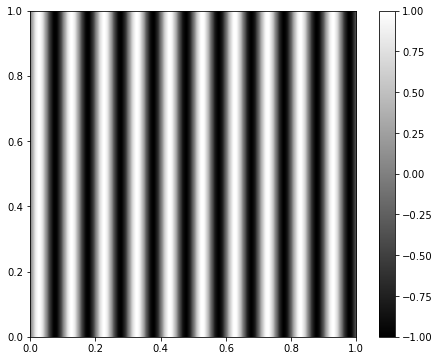

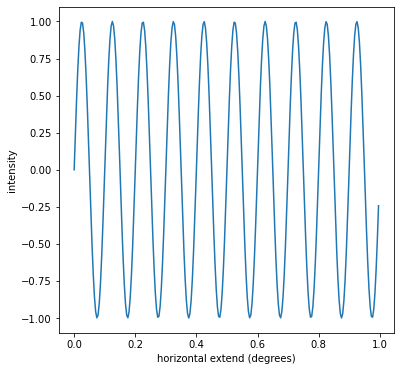

In [3]:
# Create grating with certain spatial frequency (sf in cpd)
sf = 10. 
grating = create_grating(sf)

print('the grating is %d x %d pixels' % grating.shape)
m = int(grating.shape[0]/2) # index of middle row

# Plot grating
plt.figure(figsize=(8, 6))
plt.imshow(grating, cmap='gray', extent=extent+extent)
plt.colorbar()

# plot an horizontal cut through the middle of the stimulus
plt.figure(figsize=(6, 6))
x = np.arange(extent[0], extent[1], 1/ppd)
plt.plot(x,grating[m,:])
plt.xlabel('horizontal extend (degrees)')
plt.ylabel('intensity')

## 2. We calculate the power spectrum of the image via the Fast Fourier Transform (FFT)

The FFT converts the a 2D array in the *space domain* (the image itself, with x- and  y-coordinates in space) into another 2D array in *frequency domain* (the so-called spectrum where the x and y-coordinates are frequencies).

In [4]:
# create the vector corresponding to the x and y-axis in the space domain. 
# the units are degrees,
x = np.arange(extent[0], extent[1], 1/ppd)
nX = len(x)


In [5]:
# we calculate the analogous vector for the frequency domain. numpy does this automatically 
# when passing the vector length (nX) and the step size (1/ppd). 

# Note: the output of fft functions in numpy has the following format:
# [DC, 1, 2, ..... Nyquist/2, -Nyquist/2......,-1]

# Usually in image processing use a different format, one in which the DC is in the middle.
# [-Nyquist/2......-1, DC, 1, 2, ..... Nyquist/2]
# We convert to that format with the function np.fft.fftshift
sff = np.fft.fftshift(np.fft.fftfreq(nX, d=1./ppd))

print(sff)

[-128. -127. -126. -125. -124. -123. -122. -121. -120. -119. -118. -117.
 -116. -115. -114. -113. -112. -111. -110. -109. -108. -107. -106. -105.
 -104. -103. -102. -101. -100.  -99.  -98.  -97.  -96.  -95.  -94.  -93.
  -92.  -91.  -90.  -89.  -88.  -87.  -86.  -85.  -84.  -83.  -82.  -81.
  -80.  -79.  -78.  -77.  -76.  -75.  -74.  -73.  -72.  -71.  -70.  -69.
  -68.  -67.  -66.  -65.  -64.  -63.  -62.  -61.  -60.  -59.  -58.  -57.
  -56.  -55.  -54.  -53.  -52.  -51.  -50.  -49.  -48.  -47.  -46.  -45.
  -44.  -43.  -42.  -41.  -40.  -39.  -38.  -37.  -36.  -35.  -34.  -33.
  -32.  -31.  -30.  -29.  -28.  -27.  -26.  -25.  -24.  -23.  -22.  -21.
  -20.  -19.  -18.  -17.  -16.  -15.  -14.  -13.  -12.  -11.  -10.   -9.
   -8.   -7.   -6.   -5.   -4.   -3.   -2.   -1.    0.    1.    2.    3.
    4.    5.    6.    7.    8.    9.   10.   11.   12.   13.   14.   15.
   16.   17.   18.   19.   20.   21.   22.   23.   24.   25.   26.   27.
   28.   29.   30.   31.   32.   33.   34.   35.   

In [6]:
# Calculate fft and fftshift:
gfft = np.fft.fftshift(np.fft.fft2(grating))

# the output of the FFT is an array with complex entries
# The amplitude spectrum is defined as the absolute value 
# of the complex entries (|z| = sqrt(real part ^2  + imaginary part^2))
aspectrum = np.abs(gfft)

# The power spectrum is definied as the square of the amplitude spectrum:
gpower = aspectrum**2

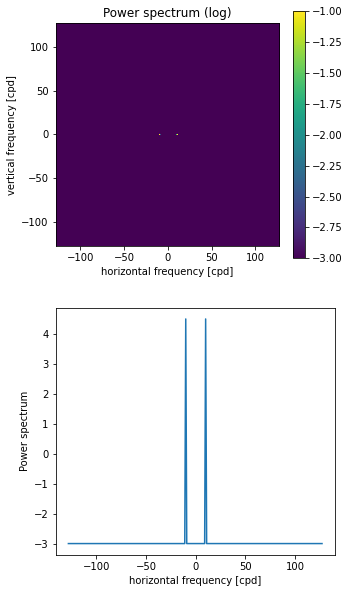

In [7]:
# we visualize the power spectrum and an horizontal cut through the mid row
plt.figure(figsize=(5, 10))
plt.subplot(211)
sff_ext = (sff[0], sff[-1], sff[0], sff[-1])
plt.imshow(np.log10(aspectrum +0.001), extent=sff_ext, vmax=-1)
plt.colorbar()
plt.title('Power spectrum (log)')
plt.xlabel('horizontal frequency [cpd]')
plt.ylabel('vertical frequency [cpd]')

plt.subplot(212)
plt.plot(sff, np.log10(aspectrum[m,:]+0.001))
plt.xlabel('horizontal frequency [cpd]')
plt.ylabel('Power spectrum')
plt.show()
    

Our sinusoidal grating is a signal with only one (horizontal) frequency. This can be seen in the spectrum as a peak at that frequency, and a mirror peak at the negative frequency.
Our grating did not vary vertically, along the y-dimension. That means, there is no frequency content for the vertical frequency. That's why we see the peaks only at a vertical frequency of zero, i.e. in the middle of the power spectrum. 

# 3. Now we put the previous two parts together in an interactive tool

In [8]:
# Helper function to plot grating and power spectrum:
# Helper function to plot grating
def plot_grating(grating_2d, gpower_2d, grating_1d, gpower_1d, extent, x, sff, vmax):
    sff_ext = (sff[0], sff[-1], sff[0], sff[-1])

    plt.figure(figsize=(10, 10))
    plt.subplot(221)
    plt.imshow(grating_2d, cmap='gray', extent=extent+extent, vmin=-1.0, vmax=1.0)
    plt.colorbar()
    plt.title('2d grating')
    plt.xlabel('deg')
    plt.ylabel('deg')

    plt.subplot(222)
    plt.imshow(np.log10(gpower_2d +0.001), extent=sff_ext, vmax=vmax)
    plt.colorbar()
    plt.title('Power spectrum (log)')
    plt.xlabel('cpd')
    plt.ylabel('cpd')

    plt.subplot(223)
    plt.plot(x, grating_1d)
    plt.title('1d grating')
    plt.xlabel('deg')
    plt.ylabel('Luminance')
    plt.ylim((-1,1))

    plt.subplot(224)
    plt.plot(sff, np.log10(gpower_1d+0.001))
    plt.xlabel('cpd')
    plt.ylabel('Power')
    plt.show()

In [9]:
# Interactively plot the grating to get to know the effect of different parameters:
def explore_grating(sf, alpha, phi, C, ppd, vmax):
    # Create sinusoidal grating:
    grating_2d = create_grating(sf, alpha=alpha, phi=phi, C=C, ppd=ppd, extent=extent)
    
    # Get 1d cut-through:
    x = np.arange(extent[0], extent[1], 1/ppd)
    nX = len(x)
    grating_1d = grating_2d[int(nX/2.), :]

    # Predefine spatial frequency axes:
    sff = np.fft.fftshift(np.fft.fftfreq(nX, d=1./ppd))

    # Calculate fft and fftshift:
    gfft_1d = np.fft.fftshift(np.fft.fft(grating_1d))
    gfft_2d = np.fft.fftshift(np.fft.fft2(grating_2d))

    # Calculate power:
    gpower_1d = np.abs(gfft_1d)**2.
    gpower_2d = np.abs(gfft_2d)**2.
    
    # Plot the grating
    plot_grating(grating_2d, gpower_2d, grating_1d, gpower_1d, extent, x, sff, vmax)  



In [10]:
interact(explore_grating, 
         sf=FloatSlider(description='spatial freq.', min=0, max=28, step=1, value=10),
         alpha=FloatSlider(description='orientation', min=-np.pi, max=np.pi, step=np.pi/8, value=0),
         phi=FloatSlider(description='phase', min=-np.pi, max=np.pi, step=np.pi/8, value=0),
         C=FloatSlider(description='contrast', min=0, max=1, step=0.1, value=1),
         ppd=FloatSlider(description='pix. per deg', min=40, max=256, step=2, value=200),
         vmax=FloatSlider(description='colorbar max', min=-3, max=10, step=1, value=-2))


interactive(children=(FloatSlider(value=10.0, description='spatial freq.', max=28.0, step=1.0), FloatSlider(va…

<function __main__.explore_grating(sf, alpha, phi, C, ppd, vmax)>

Note: While playing with the interactive tool, you might need to change the *colorbar max* variable to accommodate the colorbar range on the power spectrum visualization (top right).


Things for you to try:

- vary the spatial frequency of the grating and explore how the power spectrum changes.

- vary the phase of the grating. There is no change in the power spectrum. why?

- vary the contrast of the grating. Notice that the magnitude of the peak in the spectrum changes.

- vary the grating orientation. Notice that as soon as there is some orientation out of the horizontal, the peaks move along the vertical frequency too 

- decrease the pixels per degree variable. Notice that the resolution you will have in the frequency domain will also decrease (Nyquist theorem). You can also notice *aliasing* of the signal when you decrease it too much relative to the spatial frequency. This happens when there are insuficient number of points/samples. This can be a practical problem when we have images with small resolution (too few pixels per degree).
